<a href="https://colab.research.google.com/github/marcellataleb/plane-classification/blob/main/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  65.1M      0  0:00:40  0:00:40 --:--:-- 88.5M


In [2]:
import keras

### Imports

In [3]:
import pathlib #permet de gérer proprement le chemin d'accès 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf

from sklearn.model_selection import train_test_split

from PIL import Image

#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

### Constantes

In [4]:
# On met en majuscule car c'est une constante et ne va pas changer
DATA_DIR = pathlib.Path('dataset/data')

IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_DEPTH = 3

In [5]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep='\t',            
            names=['all'],  
            dtype={'all': str},                  
            ) 

# la fonction split() découpe une chaîne de caractères
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

# la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [ ]:
! grep 'T' dataset/data/images_manufacturer_train.txt | head #vérifie si un caractère apparaît dans un fichier ou pas

0724121 ATR
0619697 ATR
2243949 ATR
0097110 ATR
0851153 ATR
1143414 ATR
0574292 ATR
1093637 ATR
2026727 ATR
0833334 ATR


In [ ]:
# pour afficher seulement 3 lignes
! grep 'T' dataset/data/images_manufacturer_train.txt | head -3 

0724121 ATR
0619697 ATR
2243949 ATR


In [ ]:
# wc : compte le nombre d'éléments (-1 : ligne, -c : caractère, -w : word)
! grep 'T' dataset/data/images_manufacturer_train.txt | wc -l 

132


In [ ]:
! cut -f 1 -d ' ' dataset/data/images_manufacturer_train.txt | head
# d : délimiteur

1025794
1340192
0056978
0698580
0450014
1042824
0894380
1427680
0817494
0716386


In [ ]:
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [ ]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

In [ ]:
manufacturer_df.isna().sum() #une autre façon de garantir qu'il n'y a pas de valeur manquante

all             0
image_id        0
manufacturer    0
dtype: int64

In [ ]:
# Si c'est égal à 0 pas de problème, sinon il donne un message d'erreur 
assert manufacturer_df['image_id'].isna().sum() == 0, "Valeur manquante dans image_id"
assert manufacturer_df['manufacturer'].isna().sum() == 0, "Valeur manquante dans manufacturer"

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing


In [ ]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


### Functions

In [6]:
def build_image_database(path):
  """Build a pandas dataframe with target class and access path to images. 

  Parameters
  ---------
  path: path pattern to read csv file and images

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  manufacturer_df = pd.read_csv(path, sep='\t',            
            names=['all'],  
            dtype={'all': str},                  
            ) 

  # la fonction split() découpe une chaîne de caractères
  manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

  # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image 
  manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))
  
  return manufacturer_df

In [7]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt')

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg
...,...,...,...,...
3329,1577680 Yakovlev,1577680,Yakovlev,dataset/data/images/1577680.jpg
3330,1826676 Yakovlev,1826676,Yakovlev,dataset/data/images/1826676.jpg
3331,0472681 Yakovlev,0472681,Yakovlev,dataset/data/images/0472681.jpg
3332,1597829 Yakovlev,1597829,Yakovlev,dataset/data/images/1597829.jpg


In [8]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images. 

  Parameters
  ---------
  path: path pattern to read csv file and images
  target (str): name of the target column 


  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',            
            names=['all'],  
            dtype={'all': str},                  
            ) 

  # la fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image 
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))
  
  return _df.drop(columns=['all'])

In [9]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [10]:
build_image_database(DATA_DIR / 'images_family_train.txt', 'family').head(2)

,image_id,family,path
0,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192,Boeing 707,dataset/data/images/1340192.jpg


In [11]:
build_image_database(DATA_DIR / 'images_variant_train.txt', 'variant').head(2)

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg


### Load manufacturer dataset

In [12]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [13]:
manufacturer_df.head(1)['path'].values[0]

PosixPath('dataset/data/images/1025794.jpg')

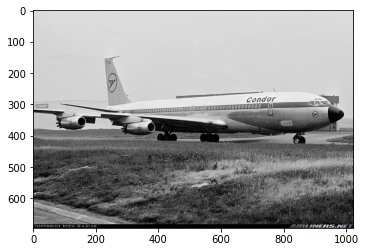

In [14]:
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

In [15]:
# La fonction : 
# - prend un df (argument)
# - prend une ligne (row: argument)
# - prend une colonne (target: argument)
# - elle affiche la classe (la valeur de target) et l'image associée pour la ligne en argument 

def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column 

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print()
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

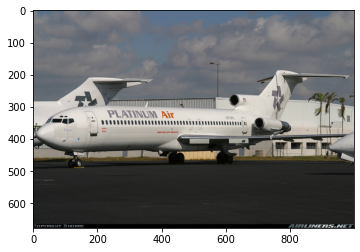

In [16]:
show_image(manufacturer_df, 42, 'manufacturer')

In [ ]:
manufacturer_df.shape

(3334, 3)

In [ ]:
manufacturer_df.head(3)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg


In [ ]:
plt.imread(manufacturer_df.head(1)['path'].values[0])

array([[[219, 219, 219],
        [218, 218, 218],
        [219, 219, 219],
        ...,
        [223, 223, 223],
        [222, 222, 222],
        [220, 220, 220]],

       [[217, 217, 217],
        [220, 220, 220],
        [222, 222, 222],
        ...,
        [219, 219, 219],
        [220, 220, 220],
        [222, 222, 222]],

       [[217, 217, 217],
        [221, 221, 221],
        [222, 222, 222],
        ...,
        [221, 221, 221],
        [223, 223, 223],
        [224, 224, 224]],

       ...,

       [[  0,   9,   8],
        [ 58,  70,  82],
        [101, 115, 128],
        ...,
        [  3,   1,   2],
        [  1,   0,   0],
        [  2,   0,   1]],

       [[  0,   2,   0],
        [  1,   2,   4],
        [  0,   2,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[  4,   0,   1],
        [  4,   0,   4],
        [  6,   0,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

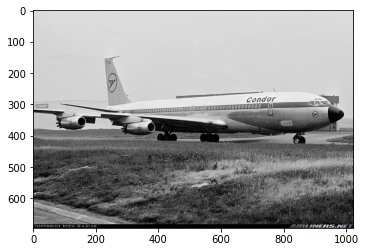

In [ ]:
# Le code au-dessus represente les pixels de l'image suivante
show_image(manufacturer_df, 0, 'manufacturer')

# La dernière matrice composée de 0 correspond au coin de la photo où il y a une partie noire. 

In [ ]:
plt.imread(manufacturer_df.head(1)['path'].values[0]).shape

(695, 1024, 3)

In [ ]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Nombre de Lignes et Nombre d'images qui contiennent ce même nombre de lignes 
manufacturer_df['shape'].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape, Length: 404, dtype: int64

In [18]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width

  Returns 
  -------
  np.array containing resized image 

  """
  return np.array(Image.open(path).resize((width, height)))

In [19]:
manufacturer_df['resized_image'] = manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

In [23]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

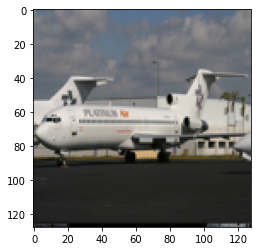

In [24]:
plt.imshow(manufacturer_df.iloc[42,]['resized_image'])

In [25]:
# Calcul du nombre de classes pour dimensionner la couche de sortie 
nb_classes = manufacturer_df['manufacturer'].nunique()

In [26]:
nb_classes

30

In [ ]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: ignored